# 可以开始训练了
- by 刘道会
- 2020-08 于重庆大学

基本流程如下：
- 导入数据集
- 导入网络模型
- 定义主函数
 - 定义训练参数
 - 定义优化器
 - 定义主循环

## 0.正式开始前还是简单先测试一下

In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from train.cornell_pro import Cornell
from train.ggcnn import GGCNN

In [2]:
#准备数据集
cornell_data = Cornell('cornell')
dataset = torch.utils.data.DataLoader(cornell_data,batch_size = 32)

#从数据集中读取一个样本
for x,y in dataset:
    xc = x
    yc = y
    break

(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)


In [3]:
#实例化一个网络
net = GGCNN(4)

#定义一个优化器
optimizer = optim.Adam(net.parameters())

#将输入传递到网络并计算输出
pos,cos,sin,width = net.forward(xc)

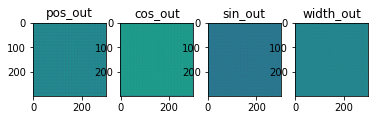

In [4]:
plt.subplot(141)
plt.title('pos_out')
plt.imshow(pos[0][0].data.numpy())
plt.subplot(142)
plt.title('cos_out')
plt.imshow(cos[0][0].data.numpy())
plt.subplot(143)
plt.title('sin_out')
plt.imshow(sin[0][0].data.numpy())
plt.subplot(144)
plt.title('width_out')
plt.imshow(width[0][0].data.numpy())
plt.show()

In [5]:
#计算损失
losses = net.compute_loss(xc,yc)
loss = losses['loss']

print(loss)

tensor(1.0594, grad_fn=<AddBackward0>)


In [6]:
#反向传播优化
optimizer.zero_grad()
loss.backward()

optimizer.step()

In [7]:
losses = net.compute_loss(xc,yc)
loss = losses['loss']

print(loss)

tensor(1.0297, grad_fn=<AddBackward0>)


可以看到经过一次优化之后，loss减小了，不过一次说明不了什么，下面就在这一个样本上优化一百次，看看loss如果变得很小的话，就说明目前的工作没有跑偏，可以继续

In [8]:
'''
device = torch.device("cuda:0")

net = net.to(device)

x = xc.to(device)
y = [yy.to(device) for yy in yc]

'''
#这些是指定GPU为训练设备的代码，但不知道为什么在jupyter notebook里面会报错，但是在spyder里面是没有问题的，训练速度那叫一个快，
#因为jupyter这边主要是为了调试，也不会真的训练，所以暂时就这样吧，不管了，用cpu就用cpu吧,不过gpu的速度比cpu快了感觉不下30倍，
#因为jupyter这开始训练之后，我spyder那边调了挺久，后面又迭代了1000次，结果回过头来jupyter这还是没迭代完100次

'\ndevice = torch.device("cuda:0")\n\nnet = net.to(device)\n\nx = xc.to(device)\ny = [yy.to(device) for yy in yc]\n\n'

In [9]:
for i in range(1):
    losses = net.compute_loss(xc,yc)
    loss = losses['loss']
    print(i)
    print(loss)
    
    #反向传播优化
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

0
tensor(1.0297, grad_fn=<AddBackward0>)


可以看到loss一直在降低，再可视化看一下它训练完后的预测结果，所以ojbk，开整

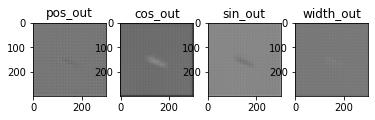

In [10]:
pos,cos,sin,width = net.forward(xc)

num = 20

plt.subplot(141)
plt.title('pos_out')
plt.imshow(pos[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(142)
plt.title('cos_out')
plt.imshow(cos[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(143)
plt.title('sin_out')
plt.imshow(sin[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(144)
plt.title('width_out')
plt.imshow(width[num][0].data.numpy(),cmap=plt.cm.gray)
plt.show()

可以看到，是比较符合预期的，所以，前面的工作已经做完了，后面可以集成了。

## 1.导入数据集并进行必要的参数设置

In [11]:
cornell_data = Cornell('cornell')
dataset = torch.utils.data.DataLoader(cornell_data,batch_size = 32,shuffle = True)

batch_size = 32
batches_per_epoch = 1000
epochs = 30
lr = 0.001


## 2.导入网络模型并进行必要的参数设置

In [12]:
#实例化一个网络
net = GGCNN(4)

## 3.定义各个子函数

### 3.1定义训练函数

In [13]:
def train(epoch,net,device,train_data,optimizer,batches_per_epoch):
    """
    :功能: 执行一个训练epoch
    :参数: epoch             : 当前所在的epoch数
    :参数: net               : 要使用的网络模型
    :参数: device            : 训练使用的设备
    :参数: train_data        : 训练所用数据集
    :参数: optimizer         : 优化器
    :参数: batches_per_epoch : 每个epoch训练中所用的数据批数

    :返回: 本epoch的平均损失
    """
    #结果字典，最后返回用
    results = {
        'loss': 0,
        'losses': {
        }
    }
    
    #训练模式，所有的层和参数都会考虑进来，eval模式下比如dropout这种层会不使能
    net.train()
    
    batch_idx = 0
    
    #开始样本训练迭代
    while batch_idx < batches_per_epoch:
        for x, y in train_data:
            batch_idx += 1
            if batch_idx >= batches_per_epoch:
                break
            
            #将数据传到GPU，目前jupyter下无法使用
            # xc = x.to(device)
            # yc = [yy.to(device) for yy in y]
            
            lossdict = net.compute_loss(xc,yc)
            
            #获取当前损失
            loss = lossdict['loss']
            
            #打印一下训练过程
            if batch_idx % 2 == 0:
                print('Epoch: {}, Batch: {}, Loss: {:0.4f}'.format(epoch, batch_idx, loss.item()))
            
            #记录总共的损失
            results['loss'] += loss.item()
            #单独记录各项损失，pos,cos,sin,width
            for ln, l in lossdict['losses'].items():
                if ln not in results['losses']:
                    results['losses'][ln] = 0
                results['losses'][ln] += l.item()
            
            #反向传播优化模型
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #计算总共的平均损失
        results['loss'] /= batch_idx
        
        #计算各项的平均损失
        for l in results['losses']:
            results['losses'][l] /= batch_idx
        return results

In [14]:
def run():
    #获取设备
    device = torch.device("cuda:0")
    #net = net.to(device)
    
    #设置优化器
    optimizer = optim.Adam(net.parameters())
    
    #开始主循环
    for epoch in range(epochs):
        train_results = train(epoch, net, device, dataset, optimizer, batches_per_epoch)

In [15]:
run()

(300, 300, 3)
(298, 300)
(298, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(253, 300)
(253, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(285, 300)
(285, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
Epoch: 0, Batch: 2, Loss: 0.8987
(300, 300, 3)
(300, 300, 3)
(300, 300,

ValueError: ('Cannot warp empty image with dimensions', (0, 300))

这边训练的时候，一开始没问题，后面报了这个错误，说是维度不匹配，有的图是[4,299,300]，这就说明是裁剪那块出了问题，上网查了一下也没什么结果，不过好在这是复现，ggcnn那边没报错，就说明它肯定是解决了这个问题的，cornell_data里面的get_depth和git_rgb有个resize函数，估计是解决这个问题的，我拿来试试

果然解决了，不过又报了一个新的错误：'Cannot warp empty image with dimensions', (0, 300))